<a href="https://colab.research.google.com/github/LucasHLirio/TCC_II/blob/main/_Pareto_front.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
import tensorflow as tf
from tensorflow import keras

Install and import the Keras Tuner.

In [ ]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.1 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt

### Download and prepare the dataset


In [ ]:
# mnist dataset
(img_train, label_train), (img_test, label_test) = keras.datasets.mnist.load_data(path="mnist.npz")

# cifar10 dataset
#(img_train, label_train), (img_test, label_test) = keras.datasets.cifar10.load_data()

#  fashion mnist dataset
#(img_train, label_train), (img_test, label_test) = keras.datasets.fashion_mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
from keras.utils import to_categorical

# Normalize pixel values between 0 and 1
img_train = img_train.astype('float32') / 255.0
img_test = img_test.astype('float32') / 255.0

# One-hot encode labels for categorical crossentropy function
label_train = to_categorical(label_train, num_classes=10)
label_test = to_categorical(label_test, num_classes=10)

## Creating custom metrics

This is necessary for easily access the values of for each model after training

In [ ]:
def crossentropy_metric(y_true, y_pred):
    res = tf.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=True)
    return tf.reduce_mean(res, axis=-1)  # Note the `axis=-1`


In [ ]:
def l2_metric(y_true, y_pred):
    res =tf.add_n([tf.nn.l2_loss(weight) for weight in model.trainable_weights])
    return tf.reduce_mean(res)  # Note the `axis=-1`


## Creating custom loss functions


###Chebysehv loss

In [ ]:
from keras import losses

class ChebyshevLoss(losses.Loss):
    def __init__(self, weights, ideal_loss_point=(0.0,0.0), name="chebyshev_loss"):
        super().__init__(name=name)
        self.ideal_loss_point = ideal_loss_point
        self.weights = weights

    def call(self, y_true, y_pred):
        # Calculates cross entropy loss (error)
        error_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=True)
        # Calculates L2 regularization (complexity)
        l2_loss = tf.add_n([tf.nn.l2_loss(weight) for weight in self.model.trainable_weights])

        # Chebyshev Scalarization involves maximizing the minimum of weights
        # Chebyshev loss is essentially the largest weighted difference of each objective to the ideal points
        weighted_error_diff = self.weights[0] * (error_loss - self.ideal_loss_point[0])
        weighted_l2_diff = self.weights[1] * (l2_loss - self.ideal_loss_point[1])

        # Combining the loss components following the Chebyshev criterion
        chebyshev_loss = tf.maximum(weighted_error_diff, weighted_l2_diff)

        return chebyshev_loss

    def get_config(self):
        config = super(ChebyshevLoss, self).get_config()
        config.update({
            "ideal_loss_point": self.ideal_loss_point,
            "weights": self.weights
        })
        return config

###Weighted sum

In [ ]:
from keras import losses

aux_sum_values = (0.0,0.0) # receives (error,l2) values for each iteration

class WeightedSum(losses.Loss):
    def __init__(self, weights, name="weightedsum_loss"):
        super().__init__(name=name)
        self.weights = weights

    def call(self, y_true, y_pred):
        # Calculates cross entropy loss (error)
        error_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=True)

        # Calculates L2 regularization (complexity)
        l2_loss = tf.add_n([tf.nn.l2_loss(weight) for weight in self.model.trainable_weights])

        aux_sum_values = (error_loss,l2_loss)

        # Combine both losses
        sum = (self.weights[0] * error_loss) + (self.weights[1] * l2_loss)

        return sum

    def get_config(self):
        config = super(WeightedSum, self).get_config()
        config.update({"weights": self.weights})
        return config

## Define the model


In [ ]:
def model_builder(weights, lossfn):

  # model structure
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))
  model.add(keras.layers.Dense(units=300, activation='relu'))
  model.add(keras.layers.Dense(10))

  # defining the loss function
  if (lossfn == 'cheby'):
    custom_loss = ChebyshevLoss(weights=weights)
  elif (lossfn == 'wgtsum'):
    custom_loss = WeightedSum(weights=weights)
  else:
    print("\nInvalid loss function!!\nChoose between 'wgtsum' or 'cheby'\n")

  custom_loss.model = model #associates a model to the loss function

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                loss=custom_loss,
                metrics=['accuracy', crossentropy_metric, l2_metric])

  return model

## Defining the training loop

###Chebyshev loss loop

In [ ]:
import time as t
import numpy as np

number_of_models = 50
cheb_values = []
loss_function = 'cheby'

cheb_start = t.time()

for i in range(number_of_models):
  weight1 = np.random.rand()
  weight2 = 1-weight1
  weights=(weight1, weight2)
  print('Model', i+1, ': weight1 =', weight1, 'and weight2 =', weight2)

  model = model_builder((weight1,weight2),loss_function)
  model.fit(img_train, label_train, epochs=10, validation_split=0.4)

  metrics = model.evaluate(img_test, label_test)
  error_value = metrics[2]
  l2_complexity = metrics[3]

  cheb_values.append((l2_complexity, error_value, weight2))

#-------------------------------------------------------------
cheb_end = t.time()

cheb_duration = (cheb_end - cheb_start)/60

print(f"\nChebyshev loop duration: {cheb_duration:.2f} minutes ")

Model 1 : weight1 = 0.605449749943603 and weight2 = 0.394550250056397
Epoch 1/10
1125/1125 [==============================] - 11s 6ms/step - loss: 2.6480 - accuracy: 0.6772 - crossentropy_metric: 1.6891 - l2_metric: 6.1846 - val_loss: 0.9894 - val_accuracy: 0.7347 - val_crossentropy_metric: 1.5963 - val_l2_metric: 2.1911
Epoch 2/10
1125/1125 [==============================] - 10s 9ms/step - loss: 0.9954 - accuracy: 0.7094 - crossentropy_metric: 1.6108 - l2_metric: 2.1589 - val_loss: 0.9889 - val_accuracy: 0.7547 - val_crossentropy_metric: 1.5950 - val_l2_metric: 2.1782
Epoch 3/10
1125/1125 [==============================] - 8s 7ms/step - loss: 0.9951 - accuracy: 0.7120 - crossentropy_metric: 1.6105 - l2_metric: 2.1594 - val_loss: 0.9899 - val_accuracy: 0.7254 - val_crossentropy_metric: 1.6145 - val_l2_metric: 2.0953
Epoch 4/10
1125/1125 [==============================] - 6s 5ms/step - loss: 0.9923 - accuracy: 0.7192 - crossentropy_metric: 1.6073 - l2_metric: 2.1549 - val_loss: 0.9887 -

Plotting the graph

Model 1: Norm L2 = 2.106816053390503, Error = 1.6011204719543457, Lambda Norm L2 = 0.394550250056397
Model 2: Norm L2 = 0.9119769930839539, Error = 1.9410728216171265, Lambda Norm L2 = 0.6609751849766183
Model 3: Norm L2 = 0.628250241279602, Error = 2.045238733291626, Lambda Norm L2 = 0.752555420004518
Model 4: Norm L2 = 1.8244287967681885, Error = 1.667344570159912, Lambda Norm L2 = 0.4472384278539622
Model 5: Norm L2 = 1.5827009677886963, Error = 1.7313090562820435, Lambda Norm L2 = 0.5006958582474452
Model 6: Norm L2 = 1.0066734552383423, Error = 1.9130079746246338, Lambda Norm L2 = 0.6310441584161726
Model 7: Norm L2 = 0.028462406247854233, Error = 2.302870750427246, Lambda Norm L2 = 0.9789125752910017
Model 8: Norm L2 = 1.2627259492874146, Error = 1.8276606798171997, Lambda Norm L2 = 0.5665158794778514
Model 9: Norm L2 = 0.12781134247779846, Error = 2.242060899734497, Lambda Norm L2 = 0.9400564612441195
Model 10: Norm L2 = 0.553085446357727, Error = 2.076740026473999, Lambda Norm 

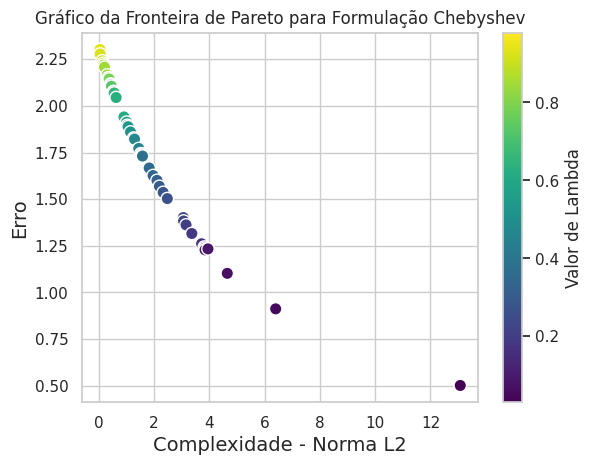

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

for i, (norm, error, w2) in enumerate(cheb_values, start=1):
    print(f"Model {i}: Norm L2 = {norm}, Error = {error}, Lambda Norm L2 = {w2}")

# Sort the Pareto front points based on L2 norm
cheb_values_sorted = sorted(cheb_values, key=lambda x:x[0])

# Get the errors and norms sorted
norms_sorted, errors_sorted, weights2_sorted = zip(*cheb_values_sorted)

# Create a scatter plot
sns.set(style="whitegrid")
plt.scatter(norms_sorted, errors_sorted, label='Fronteira de Pareto', c=np.linspace(weights2_sorted[1], weights2_sorted[-1], number_of_models), cmap='viridis', edgecolor='w', s=80)
plt.colorbar(label='Valor de Lambda')


# Add labels to the axis
plt.xlabel('Complexidade - Norma L2', fontsize=14)
plt.ylabel('Erro', fontsize=14)

# Add a title to the plot
plt.title('Gráfico da Fronteira de Pareto para Formulação Chebyshev')

# Show the graph
plt.show()

###Weighted sum loss loop

In [ ]:
number_of_models = 50
sum_values = []
loss_function = 'wgtsum'

sum_start = t.time()

#defining random weights
for i in range(number_of_models):
  weight1 = np.random.rand()
  weight2 = 1-weight1
  weights=(weight1, weight2)
  print('Model', i+1, ': weight1 =', weight1, 'and weight2 =', weight2)

  model = model_builder((weight1,weight2),loss_function)
  model.fit(img_train, label_train, epochs=10, validation_split=0.4)

  metrics = model.evaluate(img_test, label_test)
  error_value = metrics[2]
  l2_complexity = metrics[3]

  sum_values.append((l2_complexity, error_value, weight2))

#-------------------------------------------------------------
sum_end = t.time()

sum_duration = (sum_end - sum_start)/60

print(f"\nWeighted Sum loop duration: {sum_duration:.2f} minutes ")

Model 1 : weight1 = 0.8969463126366312 and weight2 = 0.10305368736336884
Epoch 1/10
1125/1125 [==============================] - 6s 4ms/step - loss: 1.9934 - accuracy: 0.8014 - crossentropy_metric: 0.9748 - l2_metric: 10.6639 - val_loss: 1.4634 - val_accuracy: 0.7877 - val_crossentropy_metric: 0.9493 - val_l2_metric: 5.9377
Epoch 2/10
1125/1125 [==============================] - 4s 4ms/step - loss: 1.4709 - accuracy: 0.8029 - crossentropy_metric: 0.9597 - l2_metric: 5.9203 - val_loss: 1.4702 - val_accuracy: 0.8191 - val_crossentropy_metric: 0.9500 - val_l2_metric: 5.9981
Epoch 3/10
1125/1125 [==============================] - 7s 6ms/step - loss: 1.4648 - accuracy: 0.8089 - crossentropy_metric: 0.9534 - l2_metric: 5.9158 - val_loss: 1.4483 - val_accuracy: 0.8202 - val_crossentropy_metric: 0.9398 - val_l2_metric: 5.8743
Epoch 4/10
1125/1125 [==============================] - 5s 4ms/step - loss: 1.4622 - accuracy: 0.8091 - crossentropy_metric: 0.9516 - l2_metric: 5.9070 - val_loss: 1.4506

Plotting the graph

Model 1: Norm L2 = 5.916293144226074, Error = 0.9140098690986633, Lambda Norm L2 = 0.10305368736336884
Model 2: Norm L2 = 4.127941608428955, Error = 1.1508578062057495, Lambda Norm L2 = 0.1407323469432452
Model 3: Norm L2 = 5.26736307144165, Error = 0.9816210269927979, Lambda Norm L2 = 0.11488480798635714
Model 4: Norm L2 = 0.0001861341152107343, Error = 2.30246901512146, Lambda Norm L2 = 0.7147386237801278
Model 5: Norm L2 = 0.00036057288525626063, Error = 2.3023083209991455, Lambda Norm L2 = 0.5088929827106929
Model 6: Norm L2 = 2.574599504470825, Error = 1.4576014280319214, Lambda Norm L2 = 0.18814753593230993
Model 7: Norm L2 = 17.13361358642578, Error = 0.37844958901405334, Lambda Norm L2 = 0.020416770922176752
Model 8: Norm L2 = 9.830340422922745e-05, Error = 2.3025028705596924, Lambda Norm L2 = 0.8449285615397828
Model 9: Norm L2 = 7.821862527634948e-05, Error = 2.302565336227417, Lambda Norm L2 = 0.8859608123104602
Model 10: Norm L2 = 0.0005032431799918413, Error = 2.3022615909

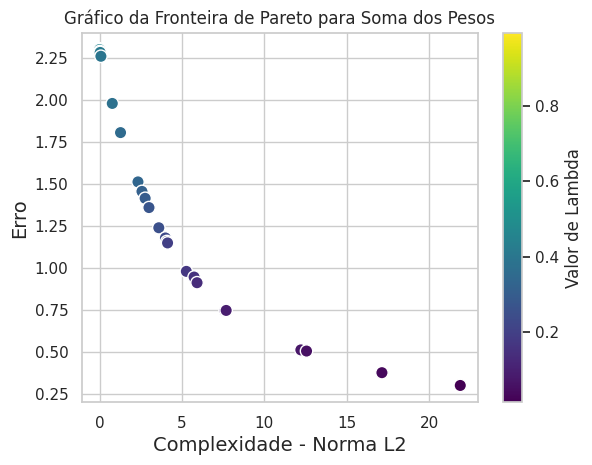

In [ ]:
for i, (norm, error, w2) in enumerate(sum_values, start=1):
    print(f"Model {i}: Norm L2 = {norm}, Error = {error}, Lambda Norm L2 = {w2}")

# Sort the Pareto front points based on L2 norm
sum_values_sorted = sorted(sum_values, key=lambda x:x[0])

# Get the errors and norms sorted
s_norms_sorted, s_errors_sorted, s_weights2_sorted = zip(*sum_values_sorted)

# Create a scatter plot
sns.set(style="whitegrid")
plt.scatter(s_norms_sorted, s_errors_sorted, label='Fronteira de Pareto', c=np.linspace(s_weights2_sorted[1], s_weights2_sorted[-1], number_of_models), cmap='viridis', edgecolor='w', s=80)
plt.colorbar(label='Valor de Lambda')

# Add labels to the axis
plt.xlabel('Complexidade - Norma L2', fontsize=14)
plt.ylabel('Erro', fontsize=14)

# Add a title to the plot
plt.title('Gráfico da Fronteira de Pareto para Soma dos Pesos')

# Show the graph
plt.show()